In [ ]:
import sys
import random

import mne
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import importlib
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from modules.BciDataHandler import BciDataHandler

data_handler = BciDataHandler()
data_handler.instantiate_dataset()

In [ ]:
# ------------------------------ bci competition dataset ------------------------------
all_subject_epochs = mne.concatenate_epochs(list(data_handler.subjects_epochs.values()))
all_labels = all_subject_epochs.events[:, -1] - 1

epochs = data_handler.subjects_epochs[1]
labels = np.array(data_handler.subjects_labels[1]) - 1

In [ ]:
# -------------------------------- ufjf dataset --------------------------------------
# from modules.EdfHandler import EdfHandler
#
# epochs, labels = EdfHandler.getAllData(["C:\\Users\\davi2\Desktop\\bci\\datasets_ufjf\\bci\\001.edf"])
# epochs = epochs[0]
# labels = np.array(labels[0])
# labels[labels == 6] = 0

In [ ]:
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci


# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1., 4.
event_id = dict(handsOrLeft=2, feetOrRight=3)

def get_physionet_data(subject, runs):

    raw_fnames = eegbci.load_data(subject, runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    eegbci.standardize(raw)  # set channel names
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage)

    # Apply band-pass filter
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

    events, _ = events_from_annotations(raw)

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)

    epochs_data = epochs.copy().crop(tmin=1., tmax=2.)

    labels = epochs.events[:, -1] - 2

    return epochs_data, labels

In [ ]:
#----------------------- physionet dataset -------------------------------------
# [6, 10, 14] hands vs feet
#[4, 8, 12] left vs right hand
# X_hf, y_hf = get_physionet_data(subject=1, runs=[6, 10, 14])
# X_lr, y_lr = get_physionet_data(subject=1, runs=[4, 8, 12])
#
# epochs = mne.concatenate_epochs([X_hf, X_lr])
# labels = np.concatenate([y_hf, y_lr+2])

In [ ]:
class ViewConv2(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return x.view((x.shape[0], x.shape[1], 1, x.shape[2]))

class Unsqueeze2(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view((x.shape[0], x.shape[1], 1))

class EmbeddingLayer(nn.Module):
    def __init__(
            self,
            n_times,
            patches_num,
            embedding_dim,
            dropout_rate,
            depth=1
    ):
        super().__init__()
        self.patches_num = patches_num
        self.embedding = nn.Linear(in_features=math.ceil(n_times*depth/self.patches_num), out_features=embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.positional_encode_table = nn.Embedding(num_embeddings=self.patches_num, embedding_dim=embedding_dim)

    #output shape -> [Batches, embeding dim, pathces,]
    def forward(self, x):
        patches = list(x.chunk(self.patches_num, dim=-1))
        patches[-1] = F.pad(patches[-1], (0, patches[0].shape[-1] - patches[-1].shape[-1]))
        patches = torch.stack(patches, dim=-2)

        #creating new dimesion for embedding (its not -1 to not bug the matrix mul)
        patches = patches.unsqueeze(-2)
        embedding_result = self.embedding(patches)

        #creating removing the unnecessary dimension to add the positional encode
        embedding_result = embedding_result.squeeze(-2)
        positional_result = embedding_result + self.positional_encode_table((torch.arange(self.patches_num, device=device)))
        out = self.dropout(positional_result)

        return out.view(out.shape[0], out.shape[2], out.shape[1])
        # return out.view(out.shape[0], out.shape[1], out.shape[3], out.shape[2])

class VisionTransformer(nn.Module):
    def __init__(
            self,
            patches,
            transformer_ffd,
            nhead = 8,
            num_layers=2
    ):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=patches, dim_feedforward=transformer_ffd, nhead=nhead, batch_first=True),
                num_layers=num_layers,
            ),
        )

    def forward(self, x):
        return self.transformer(x)


class ConvolutionSimplifier(nn.Module):
    def __init__(self, embedding_dim, dropout_rate):
        super().__init__()
        self.conv = nn.Sequential(
            nn.AdaptiveAvgPool1d(output_size=1),
            nn.Dropout(dropout_rate),
            nn.Flatten(),
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.ELU(),
        )

    def forward(self, x):
        return self.conv(x)

class FeatureExtraction(nn.Module):
    def __init__(
            self,
            n_channels,
            kernel_length,
            F1,
            D,
            F2,
            pool1_stride,
            pool2_stride,
    ):
        super().__init__()
        self.net = nn.Sequential(
            ViewConv(),
            nn.Conv2d(in_channels=n_channels, out_channels=F1, kernel_size=(1, kernel_length), bias=False, padding='same'),
            nn.BatchNorm2d(num_features=F1, momentum=0.01, eps=0.001, track_running_stats=False),
            DepthWiseConv2d(in_channels=F1, kernel_size=(n_channels, 1), kernels_per_layer=D, bias=False),
            nn.BatchNorm2d(num_features=F1*D, momentum=0.01, eps=0.001, track_running_stats=False),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, pool1_stride), stride=pool1_stride),
            SeparableConv2d(in_channels=F1*D, kernel_size=(1, 16), out_channels=F2, bias=False),
            nn.BatchNorm2d(num_features=F2, momentum=0.01, eps=0.001, track_running_stats=False),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, pool2_stride), stride=pool2_stride),
            nn.Flatten(),
        )

    def forward(self, x):
        return self.net(x)

In [406]:
from torch import nn
from Models.SubModules import ViewConv, DepthWiseConv2d, SeparableConv2d, Unsqueeze, PositionalEncoding, ToTransformer, \
    MaxNormLayer
import torch.nn.functional as F


class EEGNET(nn.Module):
    def __init__(
            self,
            n_times,
            n_classes,
            n_channels,
            patches=32,
            embedding_dim=16,
            dropout_rate=0.1,
            transformer_ffd=128,
            max_norm=0.25,
            F1=8,
            F2=16,
            D=2,
            pool1_stride=4,
            pool2_stride=8,
            kernel_length=64,
            channel_depht=1
    ):
        super().__init__()
        self.feature_extraction_output = F2 * ((((n_times - pool1_stride) // pool1_stride + 1) - pool2_stride) // pool2_stride + 1)

        self.feature_extraction = FeatureExtraction(n_channels=n_channels, kernel_length=kernel_length, F1=F1, D=D, F2=F2, pool1_stride=pool1_stride, pool2_stride=pool2_stride)

        self.embedding = EmbeddingLayer(n_times=self.feature_extraction_output, patches_num=patches, embedding_dim=embedding_dim, dropout_rate=dropout_rate)

        self.transformer = VisionTransformer(patches=patches, transformer_ffd=transformer_ffd)

        # self.conv_simplifier = ConvolutionSimplifier(embedding_dim=embedding_dim, dropout_rate=dropout_rate)

        self.head = nn.Sequential(
            nn.Linear(in_features=patches, out_features=1),
            nn.Dropout(dropout_rate),
            nn.ELU(),
            nn.Flatten(),
            MaxNormLayer(in_features=embedding_dim, out_features=n_classes, max_norm=max_norm),
        )


    def forward(self, x, targets):
        out_values = {}
        out = self.feature_extraction(x)
        out = self.embedding(out)
        out = self.transformer(out)
        # out = self.conv_simplifier(out)
        logits = self.head(out)

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets)

        return logits, loss, out_values

In [407]:
X = torch.tensor(epochs.get_data()).to(dtype=torch.float32, device=device)
y = torch.tensor(labels).to(dtype=torch.long, device=device)

In [408]:
#data augmentation
from braindecode.augmentation import FrequencyShift
from braindecode.augmentation import GaussianNoise

sfreq = epochs.info['sfreq']

freq_shift = FrequencyShift(
    probability=0.8,  # defines the probability of actually modifying the input
    sfreq=sfreq,
    max_delta_freq=2.  # the frequency shifts are sampled now between -2 and 2 Hz
)

gauss_noise = GaussianNoise(
    probability=0.8,
    std=0.01
)

transforms = {
    'freq': freq_shift,
    'gauss': gauss_noise
}

X_tr, _ = freq_shift.operation(X, None, 10., sfreq)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


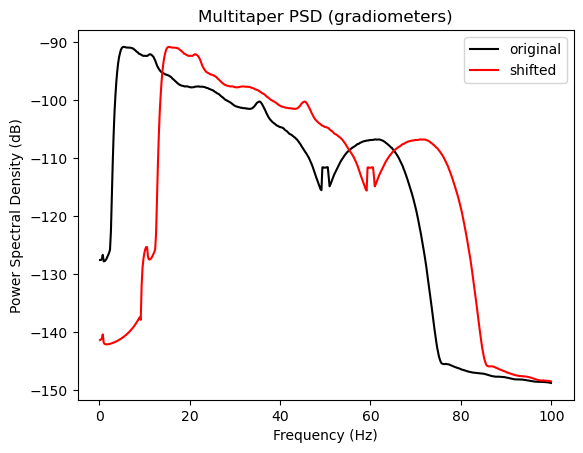

In [409]:
def plot_psd(data, axis, label, color):
    psds, freqs = mne.time_frequency.psd_array_multitaper(data, sfreq=sfreq,
                                                          fmin=0.1, fmax=100)
    psds = 10. * np.log10(psds)
    psds_mean = psds.mean(0).mean(0)
    axis.plot(freqs, psds_mean, color=color, label=label)


_, ax = plt.subplots()
plot_psd(X, ax, 'original', 'k')
plot_psd(X_tr.numpy(), ax, 'shifted', 'r')

ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')
ax.legend()
plt.show()

In [410]:
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc


class TrainerTester:

    @staticmethod
    def train_loop(model, optimizer, X_train, y_train, x_test, y_test, lr, ud, batch_size=32, iterations=1000):
        lossi = []
        accuracyi = []
        lossv = []
        accuracyv = []
        for k in range(iterations):
            batch_indexes = torch.randint(0, X_train.shape[0], (batch_size,))
            batch_test_indexes = torch.randint(0, X_test.shape[0], (batch_size,))

            X_batch, y_batch = X_train[batch_indexes], y_train[batch_indexes]  # train batch X,Y

            #data augmentation
            # X_batch, _ = transforms['freq'].operation(X_batch, None, 10., sfreq)
            # X_batch, _ = transforms['gauss'].operation(X_batch, None, std=1e-5)

            X_test_batch, y_test_batch = X_test[batch_test_indexes], y_test[batch_test_indexes]  # test batch X,Y

            pred, loss, out_values = model(X_batch,  y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #tracking training metrics
                lossi.append(loss.item())
                accuracyi.append((pred.argmax(1) == y_batch).type(torch.float32).sum().item() / y_batch.shape[0])

                #tracking test metrics
                test_loss, test_accuracy = TrainerTester.test_loss(model, X_test_batch, y_test_batch)
                lossv.append(test_loss)
                accuracyv.append(test_accuracy)

                if (k+1) % 100 == 0:
                    print(f"loss: {loss} iteration: {k+1}/{iterations}")
                    plt.title('loss')
                    plt.plot(torch.tensor(lossv).view(-1, 10).mean(dim=1).tolist(), label="test loss")
                    plt.plot(torch.tensor(lossi).view(-1, 10).mean(dim=1).tolist(), label="train loss")
                    plt.show()

                    plt.title('accuracy')
                    plt.plot(torch.tensor(accuracyv).view(-1, 10).mean(dim=1).tolist(), label="test accuracy")
                    plt.plot(torch.tensor(accuracyi).view(-1, 10).mean(dim=1).tolist(), label="train accuracy")
                    plt.show()

                ud.append([((lr * p.grad).std() / p.data.std()).item() for p in model.parameters()])

        return lossi

    @staticmethod
    def test_loss(model, X_test,  y_test):
        model.eval()
        with torch.no_grad():
            pred, loss, out_values = model(X_test, y_test)
            accuracy = (pred.argmax(1) == y_test).type(torch.float32).sum().item() / y_test.shape[0]
        model.train()
        return loss, accuracy

    @staticmethod
    def test_loop(model, X_test,  y_test):
        model.eval()
        with torch.no_grad():
            pred, loss, out_values = model(X_test, y_test)
            accuracy = (pred.argmax(1) == y_test).type(torch.float32).sum().item() / y_test.shape[0]
            kappa = cohen_kappa_score(pred.argmax(1), y_test)

        print(f"Test loss: {loss:>8f} \n Accuracy: {accuracy:>8f} \n kappa: {kappa} \n")
        model.train()
        return out_values

    @staticmethod
    def test_and_show(model, X_test,  y_test):
        model.eval()
        with torch.no_grad():
            pred, loss, out_values = model(X_test,  y_test)
            accuracy = pred.argmax(1) == y_test
            model.train()
            return accuracy


In [411]:
model = EEGNET(n_times=X.shape[-1], n_channels=len(epochs.picks), n_classes=4)
model = model.to(device=device)

In [412]:
seed = 1330
splits = 5
lr=3e-3

skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.3)

In [413]:
ud = []

#main-trianing-loop
for train_index, test_index in skf.split(X, y):
    X_train,  X_test = X[train_index], X[test_index],
    y_train, y_test = y[train_index], y[test_index]

    TrainerTester.train_loop(model, optimizer, X_train, y_train, X_test, y_test, lr, ud, batch_size=32, iterations=2000)

    out_values = TrainerTester.test_loop(model, X_test, y_test)
    break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x16 and 32x1)

In [ ]:
#params evaluation
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, np.prod(param.size()))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('total: ', params)

In [ ]:
plt.figure(figsize=(20, 10))
legends = []
i = 0
for name, p in model.named_parameters():
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append(name)
    i += 1
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
# visualize histograms
plt.figure(figsize=(40, 30)) # width and height of the plot
legends = []
for name, values in out_values.items(): # note: exclude the output value
    if name != "Softmax":
        t = values
        print(f'{name}: mean {t.mean()}, std {t.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer ({name}')
plt.legend(legends)
plt.title('gradient distribution')


In [ ]:
import re
# visualize histograms
plt.figure(figsize=(40, 20)) # width and height of the plot
legends = []
for name, params in model.named_parameters():
    if not re.search('bias', name):
        t = params.grad
        print(f'layer {name}: weight {tuple(params.shape)} | mean {t.mean()} | std {t.std()} | grad:data ratio { t.std() / params.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{name} {tuple(params.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [ ]:
import re
# visualize histograms
plt.figure(figsize=(20, 10)) # width and height of the plot
legends = []
for name, params in model.named_parameters():
    if not re.search('bias', name) and not re.search('norm', name):
        t = params
        print(f'layer {name}: weight {tuple(params.shape)} | mean {t.mean()} | std {t.std()} | weight:data ratio { t.std() / params.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{name} {tuple(params.shape)}')
plt.legend(legends)
plt.title('weights distribution');

In [ ]:
model.load_state_dict(torch.load('model_states/test_model_states.txt'))

In [ ]:
# torch.save(model.state_dict(), 'model_states/test_model_states.txt')